In [57]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Bidirectional, GlobalAveragePooling1D,GRU,Flatten
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import math
import keras_tuner as kt

In [58]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [59]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [60]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [61]:
ticker='TSLA'

In [62]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [63]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [64]:
dates = pd.to_datetime(df['Date'])

In [65]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [66]:
df_for_training = df[cols].astype(float)

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [68]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [69]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [70]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [71]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [72]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [73]:
import math as m
def n_layers(ks):
    n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
    return n

In [74]:
def build_model(hp):
    hp_ks=hp.Int('kernel_size',min_value=2,max_value=(n_past-1),step=1)
    hp_nb=hp.Int('nb_filters',min_value=2,max_value=256,step=2)
    hp_dp=hp.Float('dropout_rate',min_value=0.0,max_value=0.3,step=0.05)
    hp_gp=hp.Choice('globalpooling',[True,False])
    hp_skp=hp.Choice('skip_connections',[True,False])
    hp_acti=hp.Choice('activation',['relu','sigmoid'])
    model=Sequential()
    model.add(
            TCN(
                input_shape=(X.shape[1],X.shape[2]),
                kernel_size=hp_ks,
                return_sequences=hp_gp,
                dilations=[2**i for i in range(0,n_layers(hp_ks))],
                activation=hp_acti,
                nb_filters=hp_nb,
                padding='causal',
                dropout_rate=0.25,
                kernel_initializer='he_normal',
                use_skip_connections=hp_skp))   
    if hp_gp:
        model.add(GlobalAveragePooling1D())
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [75]:

tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_tcn_tuning',
                     )

In [76]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |kernel_size
2                 |2                 |nb_filters
0                 |0                 |dropout_rate
1                 |1                 |globalpooling
1                 |1                 |skip_connections
relu              |relu              |activation

Epoch 1/1000


2023-11-16 19:08:02.936202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-16 19:08:03.127253: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-16 19:08:03.560409: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-16 19:08:04.112110: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f52943ac3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 19:08:04.112137: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-16 19:08:04.114629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 19:08:04.163685: I ./tensorflow/compiler/jit/device_c

32/32 [==============================] - ETA: 0s - loss: 1.3938

KeyboardInterrupt: 

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 164.



Epoch 1/1000


2023-11-16 18:09:23.383199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 18:09:23.740527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 18:09:23.740572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 18:09:23.756414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-16 18:09:23.756456: I tensorflow/compile

3/3 [==============================] - 2s 186ms/step - loss: 0.0494 - val_loss: 0.1157
Epoch 2/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0373 - val_loss: 0.0959
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0273 - val_loss: 0.0784
Epoch 4/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.0192 - val_loss: 0.0632
Epoch 5/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 0.0502
Epoch 6/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0084 - val_loss: 0.0395
Epoch 7/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0308
Epoch 8/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0036 - val_loss: 0.0240
Epoch 9/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 0.0189
Epoch 10/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.0025 - val_loss: 0.0153
Epoch 11/1000
3/3 [==

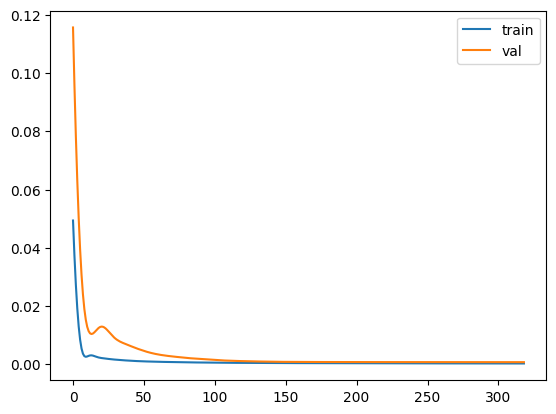

4/4 [==============================] - 0s 3ms/step
train mae: 0.7262810281312656
val mae: 0.39882103333984387


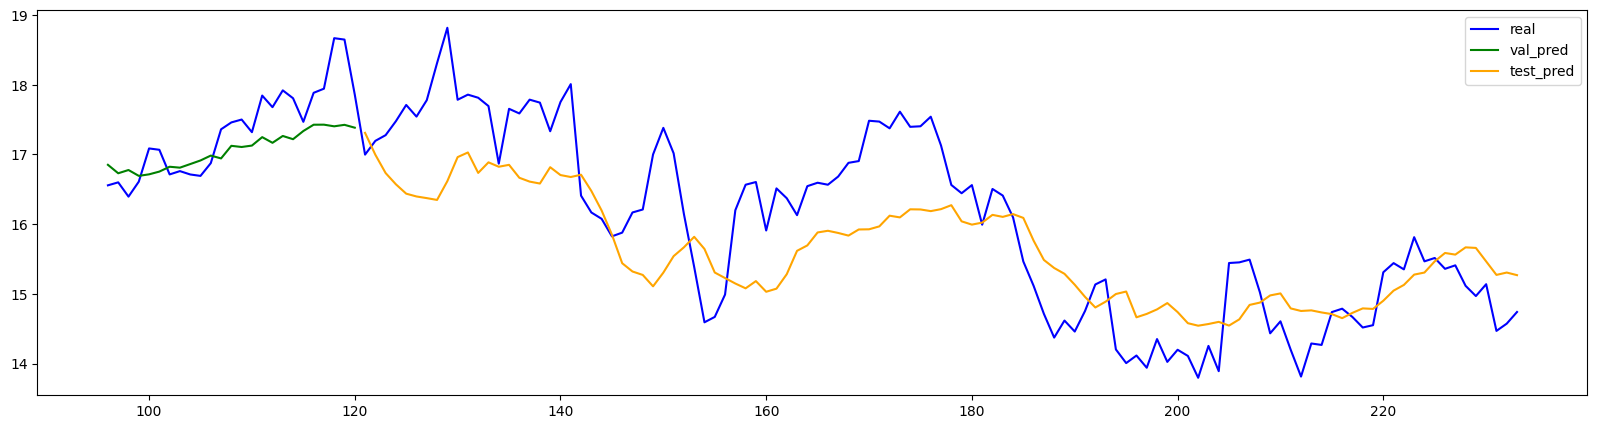

Epoch 1/1000
6/6 [==============================] - 2s 58ms/step - loss: 0.0380 - val_loss: 0.0138
Epoch 2/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0199 - val_loss: 0.0043
Epoch 3/1000
6/6 [==============================] - 0s 36ms/step - loss: 0.0094 - val_loss: 7.3375e-04
Epoch 4/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 5/1000
6/6 [==============================] - 0s 36ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 6/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 8/1000
6/6 [==============================] - 0s 34ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 9/1000
6/6 [==============================] - 0s 33ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/1000
6/6 [==============================] - 0s 34ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch

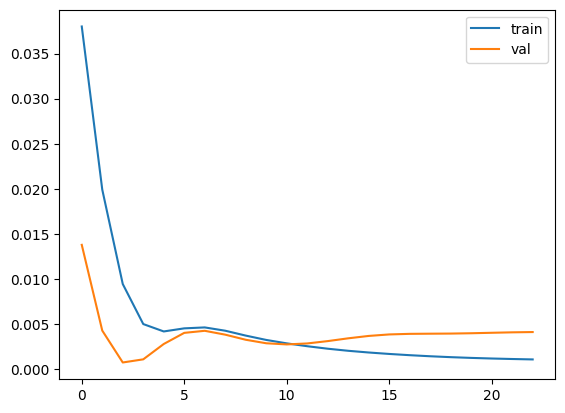

4/4 [==============================] - 0s 3ms/step
train mae: 1.297217482168552
val mae: 1.1325292291532476


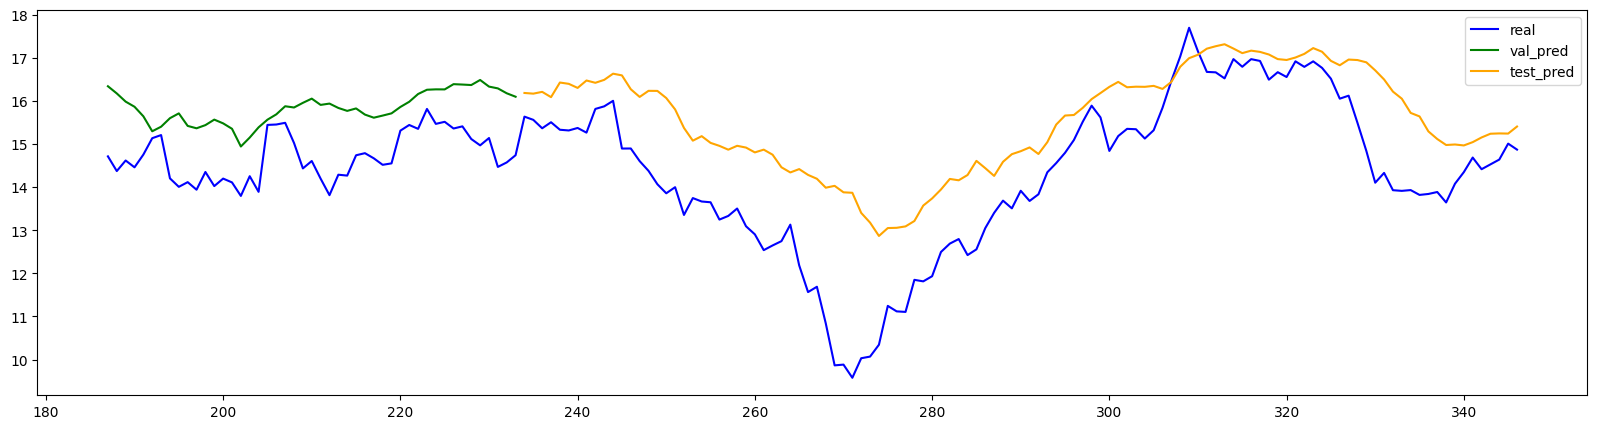

Epoch 1/1000
9/9 [==============================] - 2s 48ms/step - loss: 0.0861 - val_loss: 0.0361
Epoch 2/1000
9/9 [==============================] - 0s 36ms/step - loss: 0.0407 - val_loss: 0.0124
Epoch 3/1000
9/9 [==============================] - 0s 35ms/step - loss: 0.0160 - val_loss: 0.0034
Epoch 4/1000
9/9 [==============================] - 0s 37ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 5/1000
9/9 [==============================] - 0s 37ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 6/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 7/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 8/1000
9/9 [==============================] - 0s 34ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/1000
9/9 [==============================] - 0s 34ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/1000
9/9 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 11/

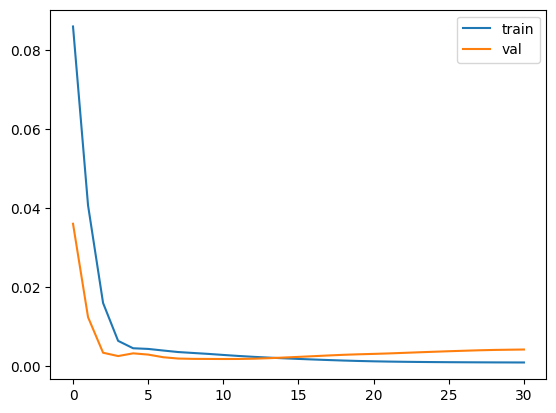

4/4 [==============================] - 0s 3ms/step
train mae: 0.6542413717527136
val mae: 1.1040920455078123


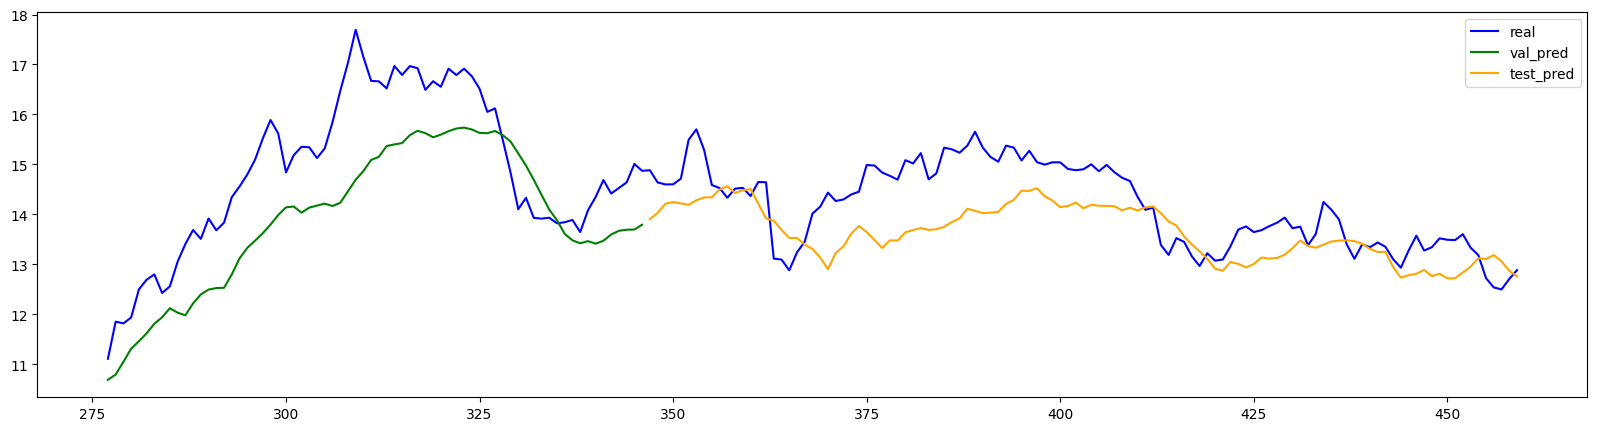

Epoch 1/1000
12/12 [==============================] - 2s 42ms/step - loss: 0.0414 - val_loss: 0.0082
Epoch 2/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0128 - val_loss: 0.0026
Epoch 3/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 4/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0071 - val_loss: 0.0040
Epoch 5/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 6/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 7/1000
12/12 [==============================] - 0s 34ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 8/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 9/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 10/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0034 - val_lo

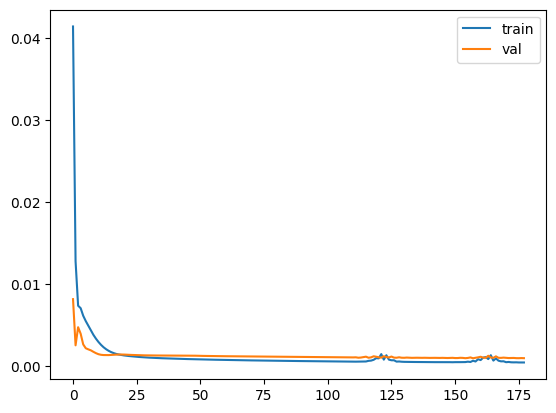

4/4 [==============================] - 0s 3ms/step
train mae: 0.5528782357172334
val mae: 0.5033231389418892


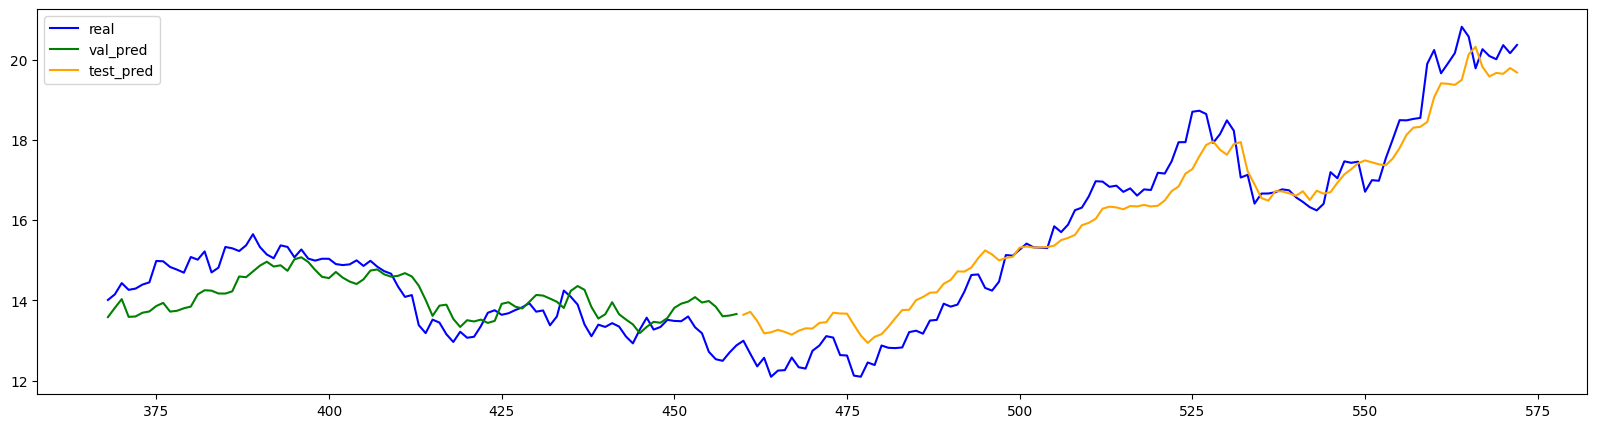

Epoch 1/1000
15/15 [==============================] - 2s 39ms/step - loss: 0.0516 - val_loss: 0.0499
Epoch 2/1000
15/15 [==============================] - 0s 31ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 3/1000
15/15 [==============================] - 1s 34ms/step - loss: 0.0063 - val_loss: 0.0115
Epoch 4/1000
15/15 [==============================] - 0s 33ms/step - loss: 0.0057 - val_loss: 0.0121
Epoch 5/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0051 - val_loss: 0.0130
Epoch 6/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0046 - val_loss: 0.0123
Epoch 7/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0040 - val_loss: 0.0112
Epoch 8/1000
15/15 [==============================] - 0s 31ms/step - loss: 0.0036 - val_loss: 0.0104
Epoch 9/1000
15/15 [==============================] - 0s 31ms/step - loss: 0.0031 - val_loss: 0.0099
Epoch 10/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0028 - val_lo

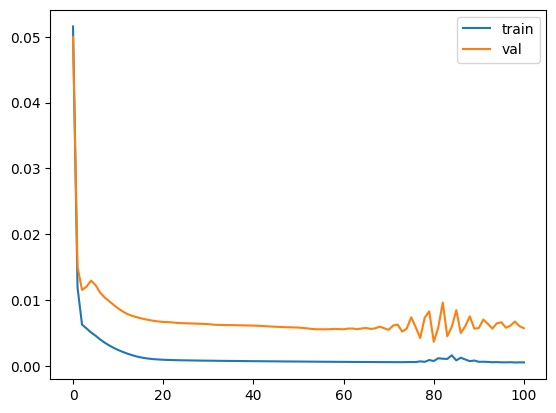

4/4 [==============================] - 0s 6ms/step
train mae: 2.4179379644829404
val mae: 1.2901623520406973


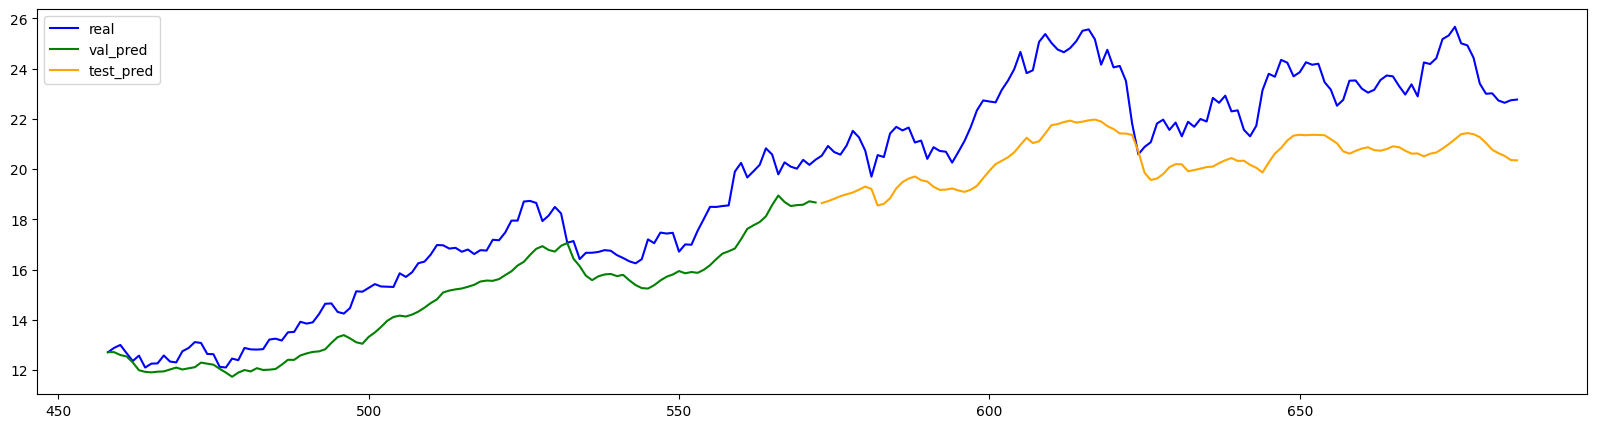

Epoch 1/1000
18/18 [==============================] - 2s 39ms/step - loss: 0.0693 - val_loss: 0.2545
Epoch 2/1000
18/18 [==============================] - 1s 34ms/step - loss: 0.0169 - val_loss: 0.1126
Epoch 3/1000
18/18 [==============================] - 1s 30ms/step - loss: 0.0079 - val_loss: 0.0840
Epoch 4/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0061 - val_loss: 0.0926
Epoch 5/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0053 - val_loss: 0.0954
Epoch 6/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0047 - val_loss: 0.0896
Epoch 7/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 0.0830
Epoch 8/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0037 - val_loss: 0.0771
Epoch 9/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0033 - val_loss: 0.0707
Epoch 10/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0030 - val_lo

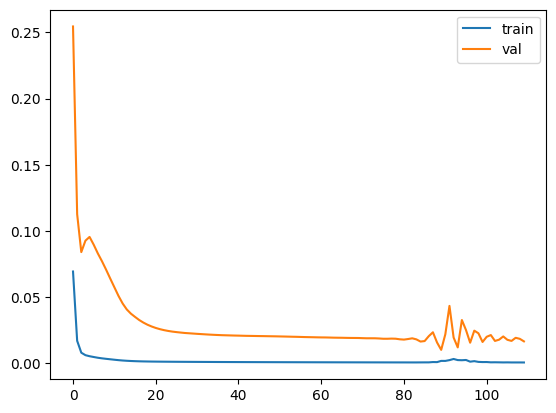

4/4 [==============================] - 0s 4ms/step
train mae: 1.8710576527682954
val mae: 2.167896307407545


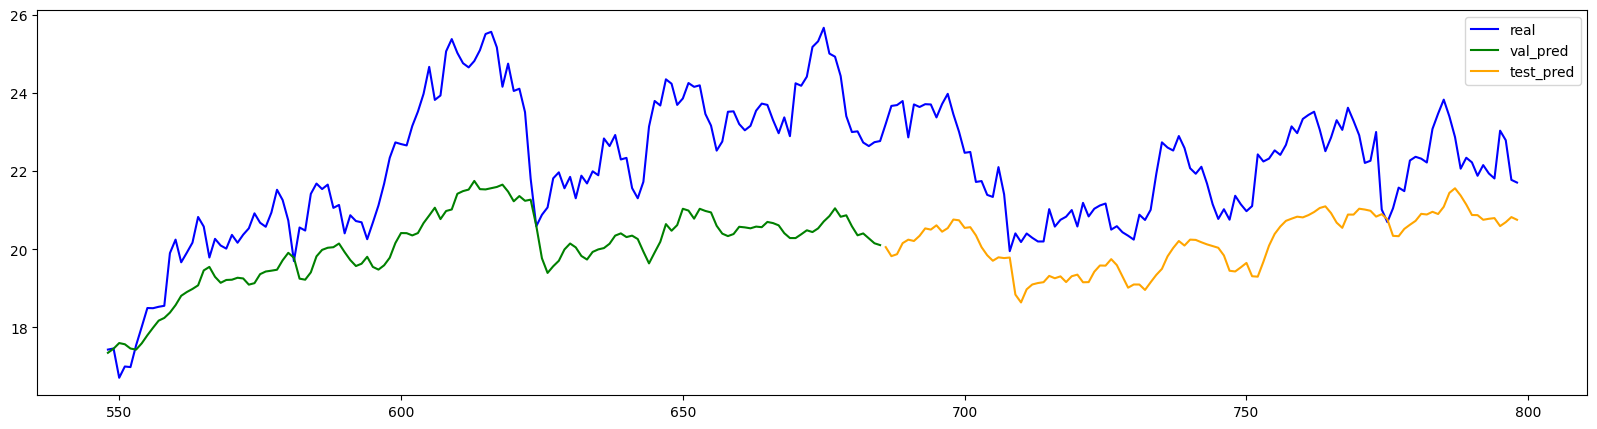

Epoch 1/1000
20/20 [==============================] - 2s 42ms/step - loss: 0.0403 - val_loss: 0.1345
Epoch 2/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.0128 - val_loss: 0.0561
Epoch 3/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.0097 - val_loss: 0.0440
Epoch 4/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.0066 - val_loss: 0.0350
Epoch 5/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 0.0230
Epoch 6/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0034 - val_loss: 0.0145
Epoch 7/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 8/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 9/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 10/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0016 - val_lo

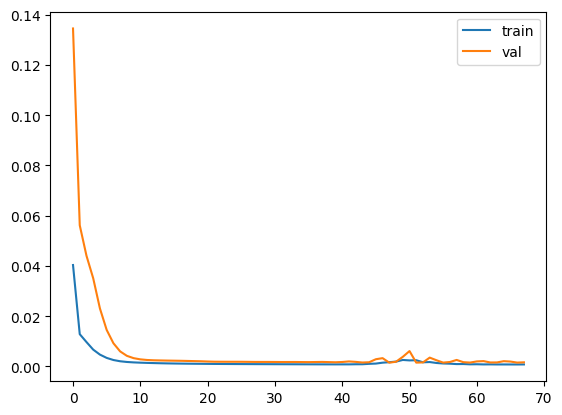

4/4 [==============================] - 0s 4ms/step
train mae: 0.9116237613611813
val mae: 0.6199410976829528


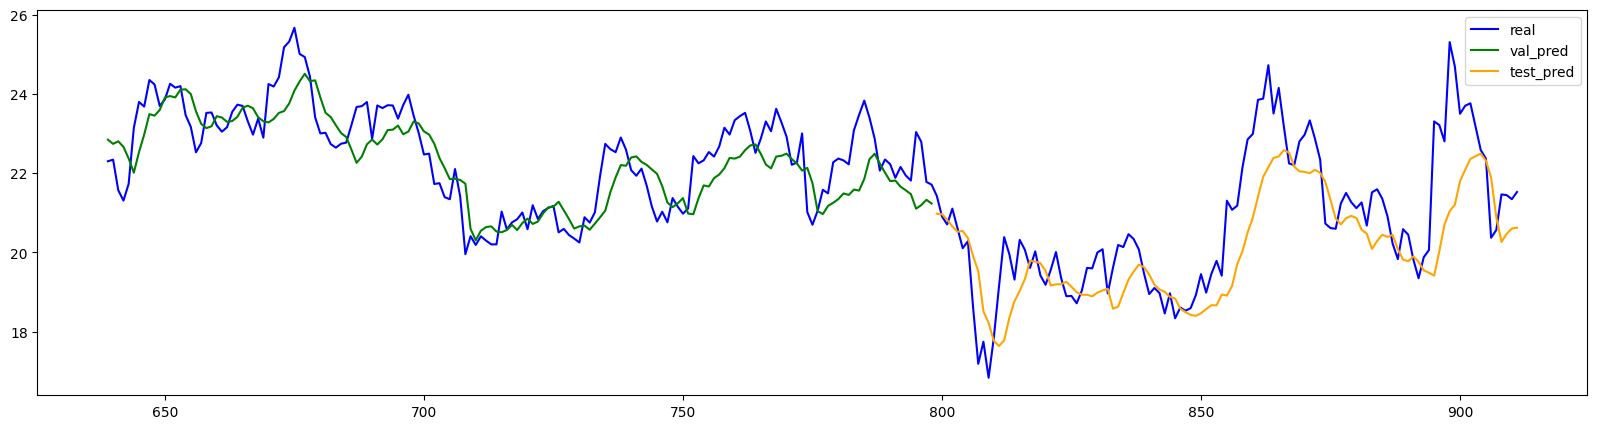

Epoch 1/1000
23/23 [==============================] - 2s 38ms/step - loss: 0.0571 - val_loss: 0.0117
Epoch 2/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 3/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 4/1000
23/23 [==============================] - 1s 30ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 5/1000
23/23 [==============================] - 1s 30ms/step - loss: 0.0058 - val_loss: 0.0188
Epoch 6/1000
23/23 [==============================] - 1s 30ms/step - loss: 0.0043 - val_loss: 0.0204
Epoch 7/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 0.0209
Epoch 8/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0030 - val_loss: 0.0200
Epoch 9/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0186
Epoch 10/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0024 - val_lo

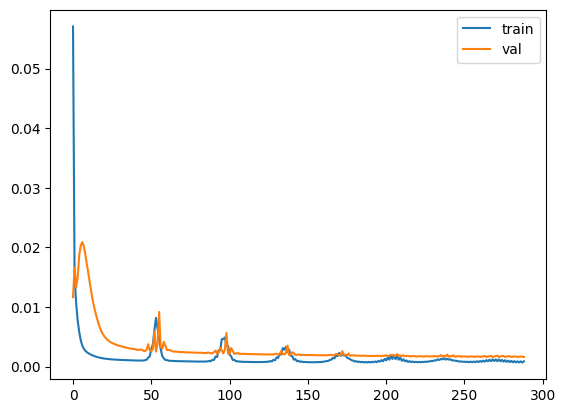

4/4 [==============================] - 0s 5ms/step
train mae: 0.7881818175524148
val mae: 0.5742302485811827


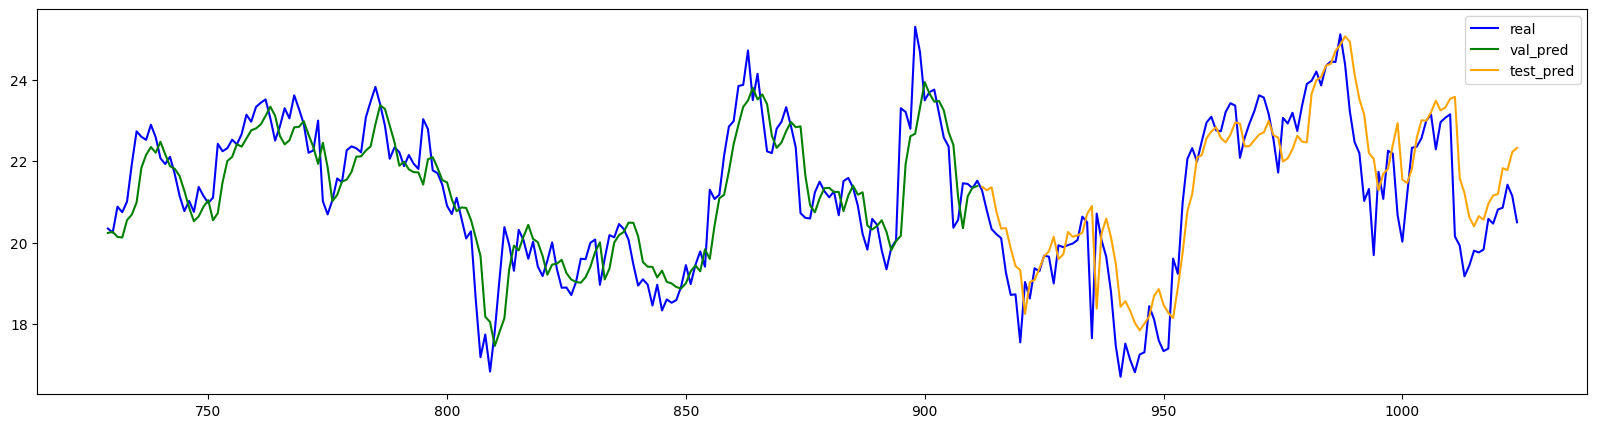

Epoch 1/1000
26/26 [==============================] - 2s 36ms/step - loss: 0.0444 - val_loss: 0.0233
Epoch 2/1000
26/26 [==============================] - 1s 32ms/step - loss: 0.0139 - val_loss: 0.0069
Epoch 3/1000
26/26 [==============================] - 1s 31ms/step - loss: 0.0112 - val_loss: 0.0069
Epoch 4/1000
26/26 [==============================] - 1s 30ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 5/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 6/1000
26/26 [==============================] - 1s 33ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 7/1000
26/26 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 8/1000
26/26 [==============================] - 1s 32ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 9/1000
26/26 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 10/1000
26/26 [==============================] - 1s 31ms/step - loss: 0.0023 - val_lo

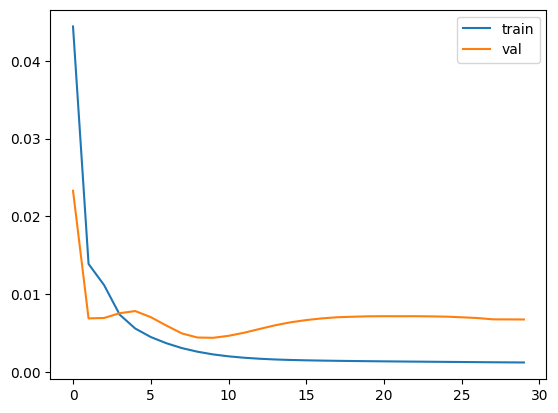

4/4 [==============================] - 0s 4ms/step
train mae: 0.6264472998948899
val mae: 1.2672815223674494


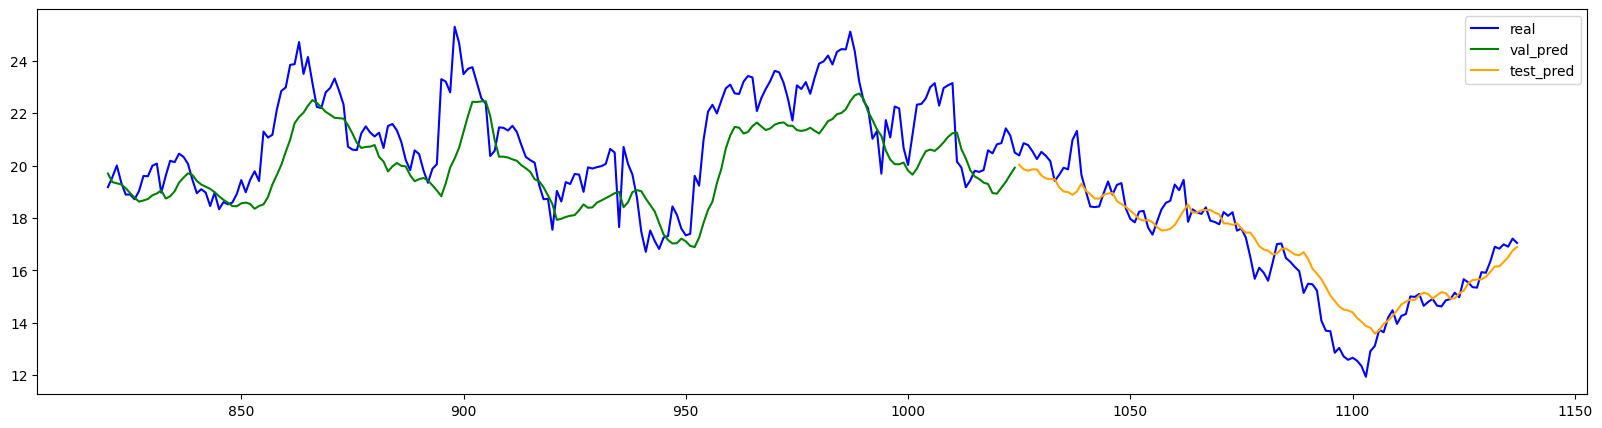

Epoch 1/1000
29/29 [==============================] - 2s 37ms/step - loss: 0.0923 - val_loss: 0.0266
Epoch 2/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0191 - val_loss: 0.0357
Epoch 3/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0177 - val_loss: 0.0452
Epoch 4/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0124 - val_loss: 0.0455
Epoch 5/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0088 - val_loss: 0.0474
Epoch 6/1000
29/29 [==============================] - 1s 30ms/step - loss: 0.0068 - val_loss: 0.0450
Epoch 7/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0054 - val_loss: 0.0403
Epoch 8/1000
29/29 [==============================] - 1s 31ms/step - loss: 0.0043 - val_loss: 0.0349
Epoch 9/1000
29/29 [==============================] - 1s 31ms/step - loss: 0.0035 - val_loss: 0.0294
Epoch 10/1000
29/29 [==============================] - 1s 31ms/step - loss: 0.0029 - val_lo

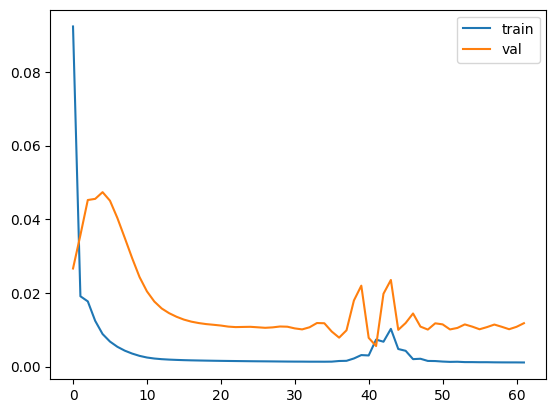

4/4 [==============================] - 0s 3ms/step
train mae: 1.7107163905428997
val mae: 1.706420696895131


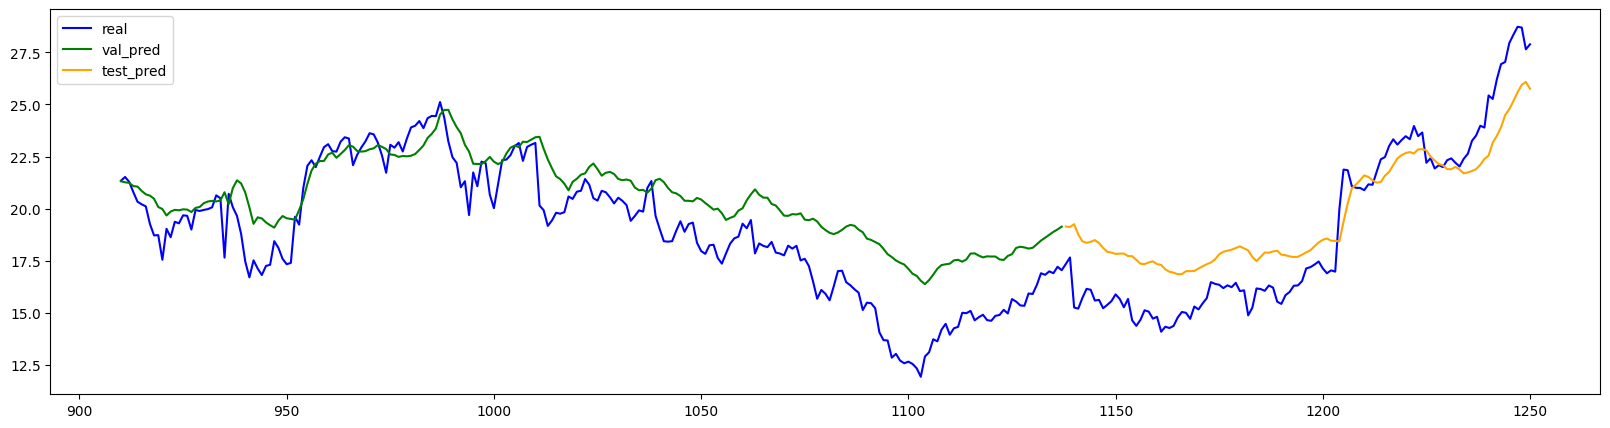

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=np.mean(np.abs(pred-y_test))
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=np.mean(np.abs(val_pred-y_val))
    v_maes.append(v_mae)
    print('val mae:',v_mae)

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()



In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 328)               180072    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 329       
                                                                 
Total params: 180401 (704.69 KB)
Trainable params: 180401 (704.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Average MAE in testing: 1.1556583004372387
Average MAE in validation: 1.0764697671917751
